## Script for Projection Catalog
### Setup

In [170]:
import numpy as np
import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from tools.setup.setup import home_dir

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()

import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo #WMAP9 cosmology
from astropy.coordinates import Distance

from tools.setup.setup import data_home_dir, home_dir
import astropy.io.fits as fits

# setup notebook for inline figures
%matplotlib inline

#file containing the rotation matrix 
toolsdir = tools_home_dir()
rotfile = toolsdir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)
    
import pkg_resources
pkg_resources.get_distribution("astropy").version

'2.0.10'

### Projection catalog
#### Add X,Y,Z columns into the projection catalog

The Cartesian (X,Y,Z) are in units of Mpc/h when converting from spherical using the SkyCoord function and distance taken from comving_distane. h0 is given by user under e.g. WMAP9 cosmology. 

Buzzard halos coordinates are in units of Mpc, not Mpc/h.

In [181]:
datadir = data_home_dir()
homedir = home_dir()
proj_dir = datadir + 'projection/'+'mock_SDSS_PlM_logNorm_lM_Simet_lobg5.fit'
proj_list = fits.open(proj_dir)
proj_data = proj_list[1].data

#Convert RA, DEC to Cartesian coordinates
h0 = cosmo.H(0).value/100.#Reduced Hubble constant

proj_dist = cosmo.comoving_distance(proj_data.Z_TR) #In units of Mpc/h
c = SkyCoord(ra=proj_data.RA*u.degree, dec=proj_data.DEC*u.degree, distance=proj_dist, frame='icrs')
proj_X = c.cartesian.x.value #in units of Mpc/h
proj_Y = c.cartesian.y.value
proj_Z = c.cartesian.z.value

#Add X,Y,Z
c1 = fits.Column(name='proj_X', array=proj_X, format='E') #E is single float precision, D for double. 
c2 = fits.Column(name='proj_Y', array=proj_Y, format='E')
c3 = fits.Column(name='proj_Z', array=proj_Z, format='E')
newcols = [c for c in proj_list[1].columns] + [c1, c2, c3]
tnew = fits.BinTableHDU.from_columns(newcols)
proj_list[1] = tnew

#Extract data
proj_data = proj_list[1].data
#Checking FITS into
#hrun_list.info()
print "Names of columns in proj_data are:"
print proj_data.names


#Converting FITS files into record array
proj_data = np.array(proj_data, dtype=proj_data.dtype)
proj_data = proj_data.view(np.recarray)

print "Number of halos is", len(proj_data)

#proj_list.writeto('projection.fits')
#print "Wrote FITS with added columns onto new FITS file."

Names of columns in proj_data are:
['M200', 'Z_TR', 'Z_OB', 'RA', 'DEC', 'LAMBDA_TR', 'LAMBDA_OB', 'proj_X', 'proj_Y', 'proj_Z']
Number of halos is 668152


### redM_matched Halos

In [139]:
#RedM_matched halos
#Read from redM_matched halos
homedir = home_dir()
redM_dir = homedir + 'output/buzzard/'+'halo_redM_matched.dat'

#Field names of the files from first row of file. Shoule be:
#('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 
#'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir')
redM_halos = np.genfromtxt(redM_dir, dtype ="i, f8, f8, f8, f8, i, f8, f8, f8, f8, f8, f8, f8, f8, f8", \
                  unpack=True, usecols=range(0,15), names=True)
redM_halos = redM_halos.view(np.recarray)

print "Names of redM_matched halo column data are:"
print redM_halos.dtype.names, "\n"
print "Number of halos read is ", len(redM_halos)

Names of redM_matched halo column data are:
('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir') 

Number of halos read is  23998


### Buzzard halos

In [140]:
buzzard_dir = datadir + 'buzzard_halo/chinchilla/' + 'Chinchilla-0_halos_all.fits'
buzz_list = fits.open(buzzard_dir)
buzz_data = buzz_list[1].data

#Checking FITS into
print "Names of columns in buzz_data are:"
print buzz_data.names

#Converting FITS files into record array
buzz_data = np.array(buzz_data, dtype=buzz_data.dtype)
buzz_data = buzz_data.view(np.recarray)
buzz_dist = cosmo.comoving_distance(buzz_data.Z)

print "\nNumber of halos is", len(buzz_data)

Names of columns in buzz_data are:
['ID', 'DESCID', 'MVIR', 'VMAX', 'VRMS', 'RVIR', 'RS', 'NP', 'PX', 'PY', 'PZ', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'SPIN', 'RS_KLYPIN', 'MVIR_ALL', 'M200B', 'M200C', 'M500C', 'M2500C', 'XOFF', 'VOFF', 'SPIN_BULLOCK', 'B_TO_A', 'C_TO_A', 'PID', 'LUMTOT', 'LUM20', 'LBCG', 'NGALS', 'N18', 'N19', 'N20', 'N21', 'N22', 'Z', 'RA', 'DEC']

Number of halos is 12198813


### Matching Projection Catalog with Chinchilla halos
* Note: astropy.comoving in units of Mpc/h 

#### Checking consistency of parameters in catalogs

In [15]:
#Sort halos by mass, and see if the most massive ones have matching properties. 
proj_sortind = np.argsort(proj_data.M200)
proj_indmax = proj_sortind[-1]
print proj_sortind
print proj_data.M200[proj_sortind]
print '\nTesting properties of largest halo in Projection Catalog'
print proj_data.dtype.names
print proj_data[proj_indmax]

#For the Chinchilla catalog. 
print '\nTesting the Chinchilla catalog'
buzz_sortind = np.argsort(buzz_data.M200B)
buzz_indmax = buzz_sortind[-1]
print buzz_data.dtype.names
buzz_maxM = buzz_data[buzz_indmax]
print buzz_maxM

print proj_data[proj_indmax].proj_X*h0, proj_data[proj_indmax].proj_Y*h0, proj_data[proj_indmax].proj_Z*h0, '\n'

#Find comoving distance of Chinchilla and cf. with Pythagoreous
print buzz_dist[buzz_indmax]*h0
print np.sqrt(buzz_maxM.PX**2. + buzz_maxM.PY**2. +  buzz_maxM.PZ**2.)

[ 51954  73901   3846 ...  26153 147129 115247]
[1.0013e+13 1.0013e+13 1.0013e+13 ... 2.3066e+15 2.5839e+15 3.3991e+15]

Testing properties of largest halo in Projection Catalog
('M200', 'Z_TR', 'Z_OB', 'RA', 'DEC', 'LAMBDA_TR', 'LAMBDA_OB', 'proj_X', 'proj_Y', 'proj_Z')
(3.3991e+15, 0.38548893, 0.37671077, 148.0982, 59.208557, 279.9802, 396.04456, -661.15247, 411.56, 1306.8656)

Testing the Chinchilla catalog
('ID', 'DESCID', 'MVIR', 'VMAX', 'VRMS', 'RVIR', 'RS', 'NP', 'PX', 'PY', 'PZ', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'SPIN', 'RS_KLYPIN', 'MVIR_ALL', 'M200B', 'M200C', 'M500C', 'M2500C', 'XOFF', 'VOFF', 'SPIN_BULLOCK', 'B_TO_A', 'C_TO_A', 'PID', 'LUMTOT', 'LUM20', 'LBCG', 'NGALS', 'N18', 'N19', 'N20', 'N21', 'N22', 'Z', 'RA', 'DEC')
(115444861, -1, 3.2463e+15, 2496.66, 2399.8, 3396.857, 872.196, 10099., -463.0979, 288.29492, 915.4397, 473.2, -266.11, -13.03, -4.375e+17, -6.957e+17, 2.044e+17, 0.03042, 773.45215, 3.2463e+15, 3.403e+15, 2.8979e+15, 1.7697e+15, 5.7837e+14, 342.71368, 

In [23]:
#Astropy has coordinate matching algorithm
#http://docs.astropy.org/en/stable/coordinates/matchsep.html

print proj_data.RA*u.degree, len(proj_data.RA*u.degree)
print proj_dist.value*u.Mpc, len(proj_dist.value*u.Mpc)

#Find distances to the catalog from redshift using WMAP9 cosmology
proj_c = SkyCoord(ra=proj_data.RA*u.degree, dec=proj_data.DEC*u.degree, distance=proj_dist.value*u.Mpc)  
buzz_c = SkyCoord(ra=buzz_data.RA*u.degree, dec=buzz_data.DEC*u.degree, distance=buzz_dist.value*u.Mpc) 

#For c.match_to_catalog_3d(catalog), c should be a subset of catalog.
idx, d2d, d3d = proj_c.match_to_catalog_3d(buzz_c) 
z_diff = proj_data.Z_TR - buzz_data.Z[idx]

[160.94777  161.2746   161.04921  ...  26.72795   27.703318  27.453608] deg 358471
[ 965.87340436  960.11768555  975.47765464 ... 2170.33580157 2189.11915568
 2199.74737629] Mpc 358471


### Apply cuts to matched catalog

In [142]:
print "Number of matched halos are ", len(idx)
uniq_idx, uniq_index = np.unique(idx, return_index=True)
idx = idx[uniq_index]; d2d = d2d[uniq_index]; d3d = d3d[uniq_index]
print "Out of which ", len(idx), " are unique"
buzz_data_matched = buzz_data[idx]
proj_ID = buzz_data_matched.ID

Number of matched halos are  324178
Out of which  324178  are unique


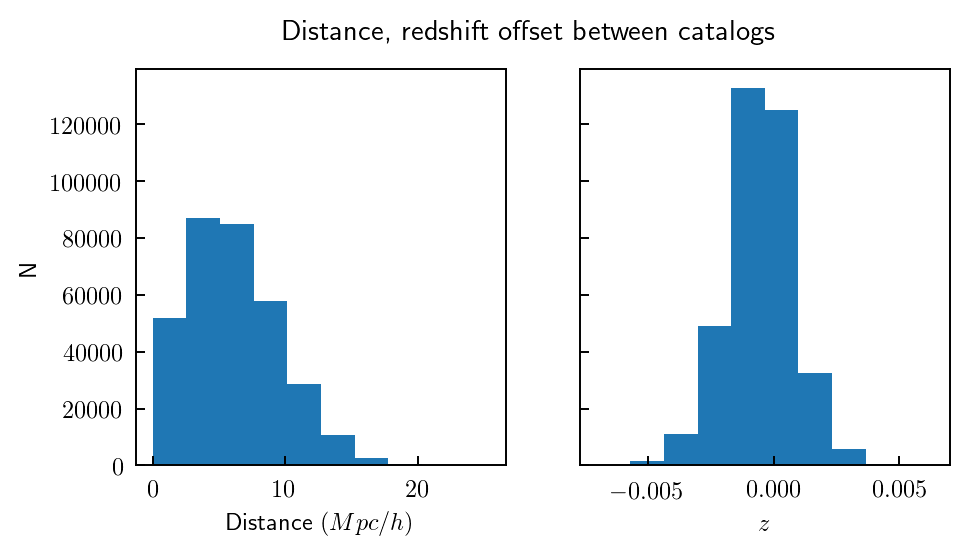

In [143]:
#Seeing the offset in distance, redshift after catalog matching
f, ax = plt.subplots(1,2, sharey=True, figsize=(6,3))
f.suptitle('Distance, redshift offset between catalogs')
ax[0].hist(d3d.value)
ax[0].set_xlabel('Distance $(Mpc/h)$')
ax[1].hist(z_diff)
ax[1].set_xlabel('$z$')
ax[0].set_ylabel(r'N')
plt.show()

## Adding parameters into the projection catalog
* Convert from (RA, DEC, Z) to (X, Y, Z)
* IDs from proximity matching to Chinchilla
* cos(i) shape information


In [182]:
from repo.halo_shape.read_shape_param import read_shape_param
from numpy.lib.recfunctions import append_fields

#Adding ID and shape info
shapedir = home_dir()+'output/buzzard/halo_shape/'
proj_shape = np.load(shapedir + 'halo_shape_projection_allz.npy')
#proj_shape = proj_shape.view(np.recarray)

halos_ID, q, s, cos_i = read_shape_param(proj_shape, convcut=False) #set convcut to false and apply cut later

#Need to re-run the proj_data reading before running this again
proj_data = append_fields(proj_data, ['ID', 'q', 's', 'cosi'], [halos_ID, q, s, cos_i], usemask=False)

### Applying cuts

* Mass cut M > 1e13
* $\lambda_{obs}$ > 10
* shape convergence cut

In [183]:
print "Initially projection catalog has halo number ", len(proj_data)

#Uniqueness matching cut -- matched uniquely matched to Buzzard halos
proj_data = proj_data[uniq_index]
print "After unique-matching cut projection catalog has halo number ", len(proj_data)

#Mass cut
mass_cut = np.where(proj_data['M200'] >= 1e13)
proj_data = proj_data[mass_cut]
print "After mass cut projection catalog has halo number ", len(proj_data)

#Lambda cut
lmda_cut = np.where(proj_data['LAMBDA_OB'] >= 5)
proj_data = proj_data[lmda_cut]
print "After lmda cut projection catalog has halo number ", len(proj_data)

#shape convergence cut
conv_cut = np.where(proj_shape['converge'] == True)
proj_data = proj_data[conv_cut]
print "After conv cut projection catalog has halo number ", len(proj_data)

Initially projection catalog has halo number  668152
After unique-matching cut projection catalog has halo number  324178
After mass cut projection catalog has halo number  324178
After lmda cut projection catalog has halo number  324178
After conv cut projection catalog has halo number  133637


In [184]:
#Save the projection data as a record array
outfile = outfile = homedir +'data/projection/proj_data.npy'
np.save(outfile, proj_data)

133637
[('M200', '<f4'), ('Z_TR', '<f4'), ('Z_OB', '<f4'), ('RA', '<f4'), ('DEC', '<f4'), ('LAMBDA_TR', '<f4'), ('LAMBDA_OB', '<f4'), ('proj_X', '<f4'), ('proj_Y', '<f4'), ('proj_Z', '<f4'), ('ID', '<i4'), ('q', '<f4'), ('s', '<f4'), ('cosi', '<f8')]


### Halo orientation catalog from halo run

In [7]:
#Rotate the halo files
import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord


#file containing the rotation matrix 
toolsdir = tools_home_dir()
rotfile = toolsdir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)

[-0.9427562  -0.94396466 -0.9427364  ...  0.8730384   0.84763545
  0.85006094]


In [29]:
#Convert RA, DEC to Cartesian coordinates
from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import Distance

#proj_dist = cosmo.comoving_distance(proj_data.Z_TR)
c = SkyCoord(ra=proj_data.RA*u.degree, dec=proj_data.DEC*u.degree, distance=proj_dist, frame='icrs')
proj_X = c.cartesian.x.value #in units of Mpc
proj_Y = c.cartesian.y.value
proj_Z = c.cartesian.z.value

##????
#Are the units in Mpc, or in Mpc/h? This figure out. 

In [30]:
proj_posvec = np.array([proj_X, proj_Y, proj_Z])
proj_rposvec = np.dot(rmat, halos_posvec)

#Rotate the Cartesian positions.
proj_X = halos_rposvec[0]; proj_Y = halos_rposvec[1]; proj_Z = halos_rposvec[2]
#convert to angular coords (in Radians)
theta, phi = hp.vec2ang(proj_rposvec.T)
proj_data['DEC'] = (np.pi/2 - theta) * 180/np.pi
proj_data['RA'] = phi * 180/np.pi
proj_DEC = proj_data['DEC']
proj_RA = proj_data['RA']
#print 'Halos DEC and RA \n', halos_data['DEC'], '\n', halos_data['RA']

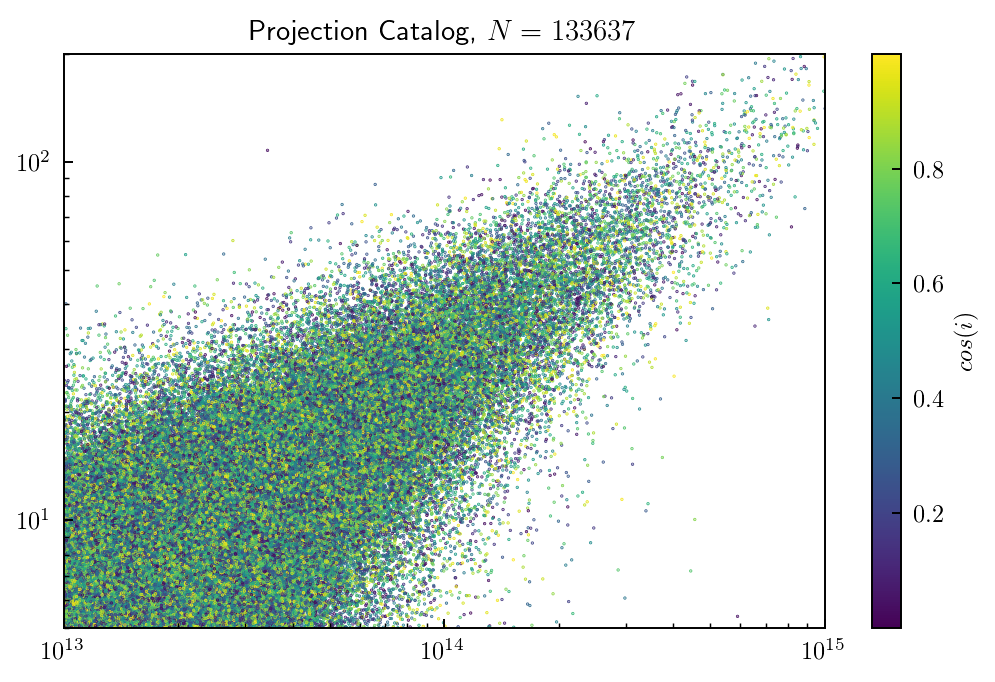

"\n#y, x = np.mgrid[slice(-3, 3 + dy, dy), slice(-3, 3 + dx, dx)]\n\n#Forget about this part for now. \nx = proj_data['M200']; y = proj_data['LAMBDA_OB']; z = proj_data['cosi']\nplt.pcolor(x, y, z, cmap=viridis, vmin=0, vmax=1)\nplt.title('pcolor')\n# set the limits of the plot to the limits of the data\nplt.axis([x.min(), x.max(), y.min(), y.max()])\nplt.colorbar()\nplt.xscale('log'); plt.yscale('log')\nplt.xlim([1e13,1e15])\nplt.ylim([5,200])\nplt.show()\n"

In [204]:
#On colomaps: https://plot.ly/matplotlib/colors-and-colormaps/
#Another good one: https://matplotlib.org/examples/pylab_examples/pcolor_demo.html
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import OrderedDict

viridis = cm.get_cmap('viridis', 256)
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(6,4))

cb1 = plt.scatter(proj_data['M200'], proj_data['LAMBDA_OB'], c = proj_data['cosi'], cmap = viridis, \
            s =0.1, label='Matteo Projection Catalog')
cbar = plt.colorbar(cb1, ax=axs)

cbar.set_label(r'$cos(i)$')

#plt.scatter(redM_halos['halos_M200b'], redM_halos['redM_lmda'], s =0.1, color='b', label='Buzzard redMaPPer matched')
plt.xscale('log'); plt.yscale('log')
plt.xlim([1e13,1e15])
plt.ylim([5,200])
plt.title(r'Projection Catalog, $N = 133637$')
#plt.legend()
plt.show()

'''
#y, x = np.mgrid[slice(-3, 3 + dy, dy), slice(-3, 3 + dx, dx)]

#Forget about this part for now. 
x = proj_data['M200']; y = proj_data['LAMBDA_OB']; z = proj_data['cosi']
plt.pcolor(x, y, z, cmap=viridis, vmin=0, vmax=1)
plt.title('pcolor')
# set the limits of the plot to the limits of the data
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xscale('log'); plt.yscale('log')
plt.xlim([1e13,1e15])
plt.ylim([5,200])
plt.show()
'''